# 4D peak fitting

In [1]:
import numpy as np
from sqlalchemy import create_engine, text
from sqlalchemy_utils import database_exists, create_database

name_dataset = "testdata"

engine = create_engine('sqlite:///../Databases/%s.db' % name_dataset) # drei Backslash für relativen Pfad

# get all peak_region_number
with engine.connect() as conn:
    try:
        peak_region_number = conn.execute(text("SELECT DISTINCT peak_region FROM %s" % name_dataset)).fetchall()
        peak_region_number = [x[0] for x in peak_region_number]
    except:
        print("Keine Verbindung möglich. Datenbank existiert nicht oder ist leer.")

In [2]:
import pandas as pd

def get_peak_region(peak_region_number):
    with engine.connect() as conn:
        try:
            peak_region = conn.execute(text("SELECT * FROM %s WHERE peak_region = %d" % (name_dataset, peak_region_number))).fetchall()
            peak_region = [x for x in peak_region]
        except:
            print("Keine Verbindung möglich. Datenbank existiert nicht oder ist leer.")
    return peak_region

In [3]:
def convert_peak_region_to_df(peak_region):
    peak_region_array = np.asarray(peak_region)
    peak_region_df = pd.DataFrame(peak_region_array, columns = ["index","rt_values", "frame_indices", "mz_values", "tof_indices", "mobility_values", "scan_indices", "intensity_values", "corrected_intensity_values", "peak_region"])
    return peak_region_df

In [4]:
peak_region_choice = np.random.choice(peak_region_number)
print("Peak Region Number: %d" % peak_region_choice)

Peak Region Number: 207


In [ ]:
import numpy as np
import tensorflow as tf

# --- 1. Datenvorbereitung ---
# Hol dir deine Peak-Region und baue daraus NumPy-Arrays
peak_region = get_peak_region(peak_region_choice)
df = convert_peak_region_to_df(peak_region)

# X: (N_samples, 3), Y: (N_samples,)
X_np = df[['rt_values', 'mobility_values', 'mz_values']].values.astype(np.float32)
Y_np = df['intensity_values'].values.astype(np.float32)
sum_intensities = np.sum(Y_np**2)

# In TensorFlow konvertieren
X = tf.constant(X_np)                  # shape [N, 3]
Y = tf.constant(Y_np)                  # shape [N]

# Dimensionen
dimensions = 3
n = dimensions

2025-05-27 08:43:01.450299: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-27 08:43:02.674071: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 08:43:03.248916: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-27 08:43:06.762217: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvi

/tmp/ipykernel_189886/1179399335.py:53: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(x_lim)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Anzahl der Punkte: 1440


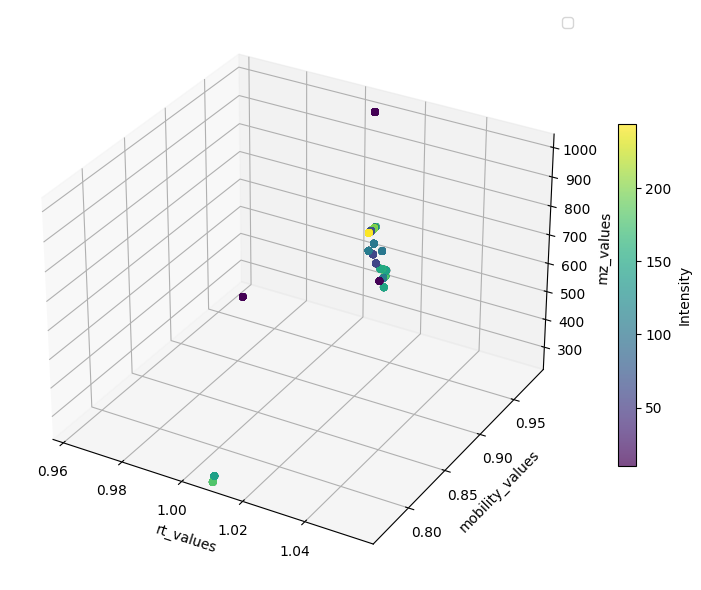

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # sorgt für den 3D-Projection-Modus

# X_np: array der Form (N,3) mit Spalten [rt_values, mobility_values, mz_values]
# Y_np: array der Form (N,) mit Intensitäten
# -----------------------------------------------

print("Anzahl der Punkte:", X_np.shape[0])

# threshold = 1/4 des Maximalwerts
threshold = Y_np.max() / 4

# Toleranz für "nahe bei threshold"
tol = (Y_np.max() - Y_np.min()) * 0.01  # z.B. 1% der Spannweite

fig = plt.figure(figsize=(8,6))
ax  = fig.add_subplot(111, projection='3d')

# 1) Normale Punkte, eingefärbt nach Y
sc = ax.scatter(
    X_np[:,0], X_np[:,1], X_np[:,2],
    c=Y_np, cmap='viridis', marker='o', alpha=0.7
)
cbar = plt.colorbar(sc, ax=ax, shrink=0.6)
cbar.set_label('Intensity')

# 2) Punkte, deren Y nahe am Schwellenwert liegen, rot hervorheben
#mask = np.abs(Y_np - threshold) < tol
#ax.scatter(
#    X_np[mask,0], X_np[mask,1], X_np[mask,2],
#    c='red', s=60, label=f'Niveau ≈ {threshold:.2f}'
#)

# 3) Achsen beschriften
ax.set_xlabel('rt_values')
ax.set_ylabel('mobility_values')
ax.set_zlabel('mz_values')

# --- Outlier entfernen ---

# 75 %-Bereich: 12.5 %/87.5 %-Quantile pro Achse
p_low, p_high = 0.0, 100.0

#p_low, p_high = 12.5, 87.5

# für jede Spalte in X_np (rt, mobility, mz) die Quantile berechnen
x_lim = np.percentile(X_np[:,0], [p_low, p_high])
y_lim = np.percentile(X_np[:,1], [p_low, p_high])
z_lim = np.percentile(X_np[:,2], [p_low, p_high])

# Achsenbegrenzungen setzen
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_zlim(z_lim)


ax.legend()
plt.tight_layout()
plt.show()


Read data

### Modelfit

#### Johnson $S_u$

In [8]:
# --- 2. Parameter als trainierbare Variablen ---
number_parameters = dimensions ** 2 + 3*dimensions + 1
params = tf.Variable(tf.random.normal([number_parameters], stddev=0.1), name="params")

# --- 3. Modell- und Fehlerfunktion definieren ---
def jsu_likelihood(params, X):
    
    # parameter length
    n = int(-3/2+ np.sqrt(5/4 + len(params.numpy())))
    # 0: alpha
    alpha = params[0]
    # gamma
    gamma = params[1:1+n]
    # zeta
    zeta = params[1+n:1+2*n]
    # delta (absolut)
    delta = tf.abs(params[1+2*n:1+3*n])
    # A-Matrix (3×3), Q = A·Aᵀ
    A = tf.reshape(params[1+3*n:], (n, n))
    #Q = tf.matmul(A, A, transpose_b=True)  # Q = A @ A.T

    # Achsentransformation: für jeden Sample-Vektor x: Q @ (x - zeta)
    centered = X - zeta                   # broadcast [N,2] - [2] → [N,2]
    transformed = tf.matmul(centered, A, transpose_b=True)  # [N,2]

    # Komponentendichten
    # rho_i = exp(-0.5*(γ_i + δ_i*asinh(t_i))²) / sqrt(1 + t_i²)
    asinh_t = tf.asinh(transformed)      # [N,2]
    exponent = -0.5 * (gamma + delta * asinh_t)**2  # broadcast [2]→[N,2]
    rho_components = tf.exp(exponent) / tf.sqrt(1 + transformed**2)  # [N,2]

    # Gesamt-Wahrscheinlichkeit: α * ∏ₖ ρₖ
    rho = alpha * tf.reduce_prod(rho_components, axis=1)  # [N]
    return rho

def loss_fn(params):
    rho = jsu_likelihood(params, X)        # Vorhersagen [N]
    # mittlere quadratische Abweichung, normalisiert durch Summe aller Intensitäten
    mse = tf.reduce_sum((Y - rho)**2) / sum_intensities
    return mse

# --- 4. Optimizer und Trainingsschleife ---
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

# Anzahl der Iterationen / Epochen
epochs = 100000

old_loss = np.inf
opt_params = None

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss = loss_fn(params)
    grads = tape.gradient(loss, [params])
    optimizer.apply_gradients(zip(grads, [params]))

    if loss.numpy() < old_loss:
        # Speichere die besten Parameter und den besten Verlust
        old_loss = loss.numpy()
        opt_params = params.numpy()

    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d}, Loss = {loss.numpy():.6e}, Best Loss = {old_loss:.6e}")

# --- 5. Ergebnisse ausgeben ---
print("Optimierte Parameter:", opt_params)
alpha_opt = opt_params[0]
print("Alpha:", alpha_opt)
gamma_opt = opt_params[1:1+dimensions]
print("Gamma:", gamma_opt)
zeta_opt = opt_params[1+dimensions:1+2*dimensions]
print("Zeta:", zeta_opt)
delta_opt = np.abs(opt_params[1+2*dimensions:1+3*dimensions])
print("Delta:", delta_opt)
A_opt = np.reshape(opt_params[1+3*dimensions:], (dimensions, dimensions))
print("A-Matrix:", A_opt)
opt_loss = loss_fn(tf.convert_to_tensor(opt_params, dtype=tf.float32)).numpy()
print("Finaler Fehler:", opt_loss)


Epoch    0, Loss = 1.000000e+00, Best Loss = 1.000000e+00
Epoch  200, Loss = 9.995633e-01, Best Loss = 9.940439e-01
Epoch  400, Loss = 9.995933e-01, Best Loss = 9.921764e-01
Epoch  600, Loss = 9.999959e-01, Best Loss = 9.910334e-01
Epoch  800, Loss = 9.999959e-01, Best Loss = 9.910334e-01
Epoch 1000, Loss = 9.999959e-01, Best Loss = 9.910334e-01
Epoch 1200, Loss = 9.999959e-01, Best Loss = 9.910334e-01
Epoch 1400, Loss = 9.999959e-01, Best Loss = 9.910334e-01
Epoch 1600, Loss = 9.999956e-01, Best Loss = 9.910334e-01
Epoch 1800, Loss = 9.999956e-01, Best Loss = 9.910334e-01
Epoch 2000, Loss = 9.999952e-01, Best Loss = 9.910334e-01
Epoch 2200, Loss = 9.999950e-01, Best Loss = 9.910334e-01
Epoch 2400, Loss = 9.999950e-01, Best Loss = 9.910334e-01
Epoch 2600, Loss = 9.999948e-01, Best Loss = 9.910334e-01
Epoch 2800, Loss = 9.999947e-01, Best Loss = 9.910334e-01
Epoch 3000, Loss = 9.999941e-01, Best Loss = 9.910334e-01
Epoch 3200, Loss = 9.999939e-01, Best Loss = 9.910334e-01
Epoch 3400, Lo

### weitere Verteilungen

In [65]:
def train(params, dichte, epochs = 100000, learning_rate=1e-2):

    def loss_fn(params):
        rho = dichte(params, X)        # Vorhersagen [N]
        # mittlere quadratische Abweichung, normalisiert durch Summe aller Intensitäten
        mse = tf.reduce_sum((Y - rho)**2) / sum_intensities
        return mse

    # --- 4. Optimizer und Trainingsschleife ---
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Anzahl der Iterationen / Epochen
    #epochs = 20000

    old_loss = np.inf
    opt_params = None

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss = loss_fn(params)
        grads = tape.gradient(loss, [params])
        optimizer.apply_gradients(zip(grads, [params]))

        if loss.numpy() < old_loss:
            # Speichere die besten Parameter und den besten Verlust
            old_loss = loss.numpy()
            opt_params = params.numpy()

        if epoch % 200 == 0:
            print(f"Epoch {epoch:4d}, Loss = {loss.numpy():.6e}, Best Loss = {old_loss:.6e}")

    # --- 5. Ergebnisse ausgeben ---
    print("Optimierte Parameter:", opt_params)
    opt_loss = loss_fn(tf.convert_to_tensor(opt_params, dtype=tf.float32)).numpy()
    print("Finaler Fehler:", opt_loss)
    return opt_params


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D  # muss importiert sein, auch wenn nicht direkt verwendet

def plot(params, dichte):
    
    # estimate function value
    intensity_estimate = dichte(tf.convert_to_tensor(params, dtype=tf.float32), X_np).numpy() 

    

    # 1) Gitter erstellen
    X_mesh, Y_mesh = np.meshgrid(x, y)

    # 2) gemeinsame Farbskalierung von 0…1
    norm = Normalize(vmin=0, vmax=1)

    # 3) Figure und 3D-Achse
    fig, axes = plt.subplots(
        1, 3, 
        subplot_kw={'projection': '3d'}, 
        figsize=(20, 6)
    )

    for ax, Zdata, title in zip(
        axes,
        [Y_np, np.abs(Y_np - intensity_estimate), intensity_estimate],
        ['Original', 'Difference', 'Estimate']
    ):

        sc = ax.scatter(
            X_np[:,0], X_np[:,1], X_np[:,2],
            c=Zdata, cmap='viridis', marker='o', alpha=0.7
        )
        cbar = plt.colorbar(sc, ax=ax, shrink=0.6)
        cbar.set_label('Intensity')

        # 2) Punkte, deren Y nahe am Schwellenwert liegen, rot hervorheben
        #mask = np.abs(Y_np - threshold) < tol
        #ax.scatter(
        #    X_np[mask,0], X_np[mask,1], X_np[mask,2],
        #    c='red', s=60, label=f'Niveau ≈ {threshold:.2f}'
        #)

        # 3) Achsen beschriften
        ax.set_xlabel('rt_values')
        ax.set_ylabel('mobility_values')
        ax.set_zlabel('mz_values')

        ax.set_title(title)

    # gemeinsame Colorbar
    #fig.colorbar(surf, ax=axes.tolist(), shrink=0.5, aspect=10, label='height')
    plt.tight_layout()
    plt.show()


#### Tukey-g-and-h–Verteilung

Gefunden: https://arxiv.org/pdf/2411.07957

- Formel (multivariat):

$$
p(x)=\alpha \prod_{i=1}^n|\underbrace{\frac{d}{d z}\left[\frac{e^{g_i z}-1}{g_i} e^{\frac{h_i z^2}{2}}\right]}_{d Q_i / d z}|_{z=(A(x-\zeta))_i} .
$$


In [ ]:
# --- Parameterzahl und Variablen ---
# params = [alpha, zeta(n), g(n), h(n>=0), A(n×n)]
num_params = 1 + n + n + n + n*n
params = tf.Variable(tf.random.normal([num_params], stddev=0.1), name="gh_params")

def tukey_gh_mvd(params, X):
    alpha = params[0]
    zeta  = params[1:1+n]
    g     = params[1+n:1+2*n]
    h     = tf.nn.relu(params[1+2*n:1+3*n])       # h ≥ 0
    A_flat= params[1+3*n:]
    A     = tf.reshape(A_flat, (n,n))

    #print("X.shape: ", X.shape)
    #print("zeta.shape: ", zeta.shape)

    # Whitening
    centered = X - zeta                           # [N,n]
    Z        = tf.matmul(centered, A, transpose_b=True)  # [N,n]

    # Quantil-Funktion und ihr Ableiter:
    # Q(z) = (e^{g z} - 1)/g * e^{h z^2/2}
    exp_gz = tf.exp(g * Z)
    W      = (exp_gz - 1) / g                     # [N,n]
    e_h    = tf.exp(0.5 * h * Z**2)               # [N,n]

    # dQ/dz = e^{h z^2/2} * ( e^{g z} + W * h * z )
    dQdz   = e_h * (exp_gz + W * h * Z)           # [N,n]

    rho = alpha * tf.reduce_prod(tf.abs(dQdz), axis=1)  # [N]
    return rho


In [69]:
params_tukey_gh = train(params, tukey_gh_mvd)

Epoch    0, Loss = 7.815629e-01, Best Loss = 7.815629e-01
Epoch  200, Loss = 3.601559e-02, Best Loss = 3.601559e-02
Epoch  400, Loss = 3.574219e-02, Best Loss = 3.574219e-02
Epoch  600, Loss = 3.544035e-02, Best Loss = 3.544035e-02
Epoch  800, Loss = 3.514355e-02, Best Loss = 3.514355e-02
Epoch 1000, Loss = 3.486661e-02, Best Loss = 3.486661e-02
Epoch 1200, Loss = 3.461292e-02, Best Loss = 3.461292e-02
Epoch 1400, Loss = 3.437797e-02, Best Loss = 3.437797e-02
Epoch 1600, Loss = 3.415044e-02, Best Loss = 3.415044e-02
Epoch 1800, Loss = 3.391234e-02, Best Loss = 3.391234e-02
Epoch 2000, Loss = 3.363934e-02, Best Loss = 3.363934e-02
Epoch 2200, Loss = 3.330407e-02, Best Loss = 3.330407e-02
Epoch 2400, Loss = 3.288602e-02, Best Loss = 3.288602e-02
Epoch 2600, Loss = 3.239693e-02, Best Loss = 3.239693e-02
Epoch 2800, Loss = 3.191759e-02, Best Loss = 3.191759e-02
Epoch 3000, Loss = 3.158529e-02, Best Loss = 3.158529e-02
Epoch 3200, Loss = 3.143939e-02, Best Loss = 3.143350e-02
Epoch 3400, Lo

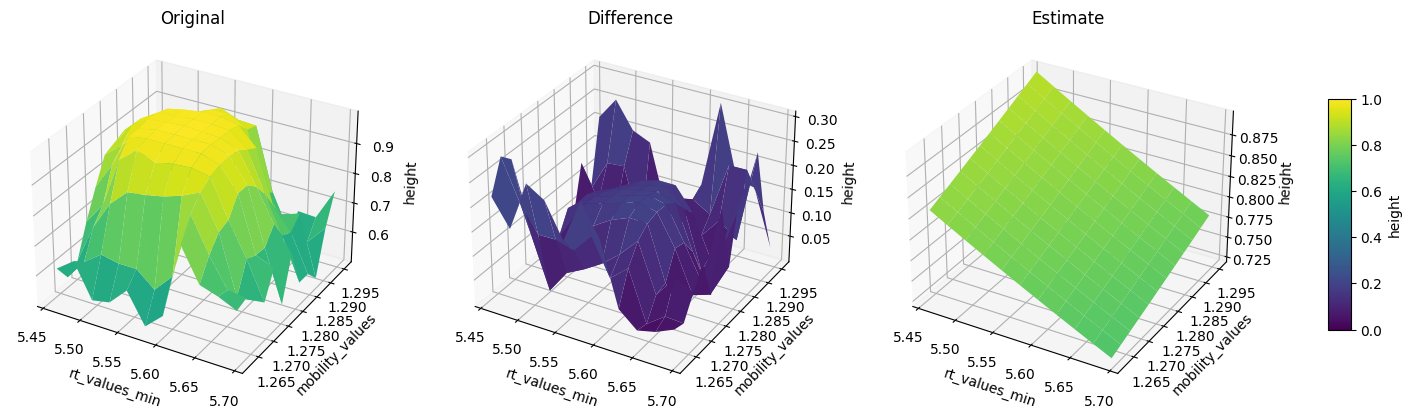

In [70]:
plot(params_tukey_gh, tukey_gh_mvd)

#### Normalverteilung

\begin{equation}
p(x)=\alpha \exp \left(-\frac{1}{2} y^{\top} y\right), \quad y=A(x-\zeta) .
\end{equation}

In [ ]:
# --- Parameterzahl und Variablen ---
# params = [alpha, zeta(n), A(n×n)]
num_params = 1 + n + n*n
params = tf.Variable(tf.random.normal([num_params], stddev=0.1), name="normal_params")

def normal_mvd(params, X):
    alpha = params[0]
    zeta  = params[1:1+n]
    A_flat= params[1+n:]
    A     = tf.reshape(A_flat, (n,n))

    centered = X - zeta
    Y        = tf.matmul(centered, A, transpose_b=True)  # [N,n]

    # univariate Normal (bis auf Konstanten): exp(-½ z^2)
    rho_comp = tf.exp(-0.5 * Y**2)                        # [N,n]

    rho = alpha * tf.reduce_prod(rho_comp, axis=1)       # [N]
    return rho


In [72]:
params_normal = train(params, normal_mvd)

Epoch    0, Loss = 9.201890e-01, Best Loss = 9.201890e-01
Epoch  200, Loss = 3.386807e-02, Best Loss = 3.386807e-02
Epoch  400, Loss = 3.369213e-02, Best Loss = 3.369213e-02
Epoch  600, Loss = 3.314237e-02, Best Loss = 3.314237e-02
Epoch  800, Loss = 3.199117e-02, Best Loss = 3.195385e-02
Epoch 1000, Loss = 3.124785e-02, Best Loss = 3.124785e-02
Epoch 1200, Loss = 3.100331e-02, Best Loss = 3.100331e-02
Epoch 1400, Loss = 3.092428e-02, Best Loss = 3.092428e-02
Epoch 1600, Loss = 3.087766e-02, Best Loss = 3.087766e-02
Epoch 1800, Loss = 3.081694e-02, Best Loss = 3.081694e-02
Epoch 2000, Loss = 3.072142e-02, Best Loss = 3.072142e-02
Epoch 2200, Loss = 3.057720e-02, Best Loss = 3.057720e-02
Epoch 2400, Loss = 3.035208e-02, Best Loss = 3.035208e-02
Epoch 2600, Loss = 2.998840e-02, Best Loss = 2.998840e-02
Epoch 2800, Loss = 2.940399e-02, Best Loss = 2.940399e-02
Epoch 3000, Loss = 2.851996e-02, Best Loss = 2.851996e-02
Epoch 3200, Loss = 2.737016e-02, Best Loss = 2.737016e-02
Epoch 3400, Lo

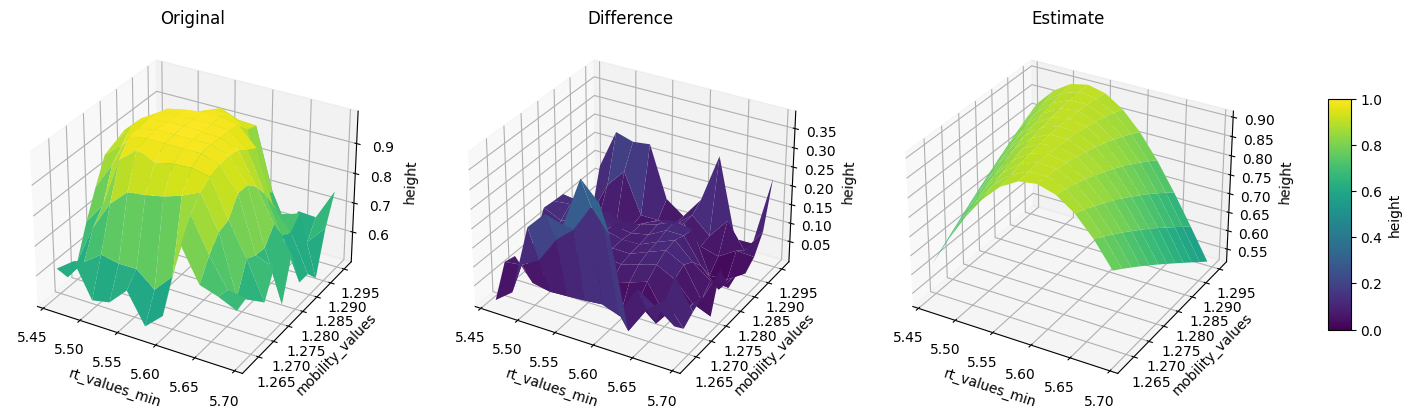

In [73]:
plot(params_normal, normal_mvd)

#### Exponentially Modified Gaussian

Univariat ist

$$
f(x ; \mu, \sigma, \lambda)=\frac{\lambda}{2} \exp \left[\frac{\lambda}{2}\left(2 \mu+\lambda \sigma^2-2 x\right)\right] \operatorname{erfc}\left(\frac{\mu+\lambda \sigma^2-x}{\sqrt{2} \sigma}\right) .
$$


Setzen wir $\mu=0, \sigma=1$ (das Whitening übernimmt A), so gilt (bis auf konstanten Faktor) $\rho(y ; \lambda) \propto \exp (-\lambda y) \quad \operatorname{erfc}((\lambda-y) / \sqrt{2})$.

Formel multivariat:
\begin{equation}
p(x)=\alpha \prod_{i=1}^n\left[\exp \left(-\lambda_i y_i\right) \quad \operatorname{erfc}\left(\frac{\lambda_i-y_i}{\sqrt{2}}\right)\right], \quad y=A(x-\zeta) .
\end{equation}

In [ ]:
# --- Parameterzahl und Variablen ---
# params = [alpha, zeta(n), lambda(n>0), A(n×n)]
num_params = 1 + n + n + n*n
params = tf.Variable(tf.random.normal([num_params], stddev=0.1), name="emg_params")

def emg_mvd(params, X):
    alpha = params[0]
    zeta  = params[1:1+n]
    lam   = tf.nn.softplus(params[1+n:1+2*n])  # λ>0
    A_flat= params[1+2*n:]
    A     = tf.reshape(A_flat, (n,n))

    centered = X - zeta
    Y        = tf.matmul(centered, A, transpose_b=True)  # [N,n]

    # univ. EMG-Dichte (bis auf Konstanten):
    erfc_arg = (lam - Y) / tf.sqrt(2.0)
    rho_comp = tf.exp(-lam * Y) * tf.math.erfc(erfc_arg)  # [N,n]

    rho = alpha * tf.reduce_prod(rho_comp, axis=1)       # [N]
    return rho


In [75]:
params_emg = train(params, emg_mvd)

Epoch    0, Loss = 1.009262e+00, Best Loss = 1.009262e+00
Epoch  200, Loss = 3.345186e-02, Best Loss = 3.345186e-02
Epoch  400, Loss = 3.318964e-02, Best Loss = 3.318964e-02
Epoch  600, Loss = 3.288525e-02, Best Loss = 3.288525e-02
Epoch  800, Loss = 3.253917e-02, Best Loss = 3.253917e-02
Epoch 1000, Loss = 3.218568e-02, Best Loss = 3.218568e-02
Epoch 1200, Loss = 3.188283e-02, Best Loss = 3.188283e-02
Epoch 1400, Loss = 3.167010e-02, Best Loss = 3.167010e-02
Epoch 1600, Loss = 3.153997e-02, Best Loss = 3.153997e-02
Epoch 1800, Loss = 3.145340e-02, Best Loss = 3.145340e-02
Epoch 2000, Loss = 3.136250e-02, Best Loss = 3.136250e-02
Epoch 2200, Loss = 3.123164e-02, Best Loss = 3.123164e-02
Epoch 2400, Loss = 3.101974e-02, Best Loss = 3.101974e-02
Epoch 2600, Loss = 3.063516e-02, Best Loss = 3.063516e-02
Epoch 2800, Loss = 2.989687e-02, Best Loss = 2.989687e-02
Epoch 3000, Loss = 2.861699e-02, Best Loss = 2.861699e-02
Epoch 3200, Loss = 2.690247e-02, Best Loss = 2.690247e-02
Epoch 3400, Lo

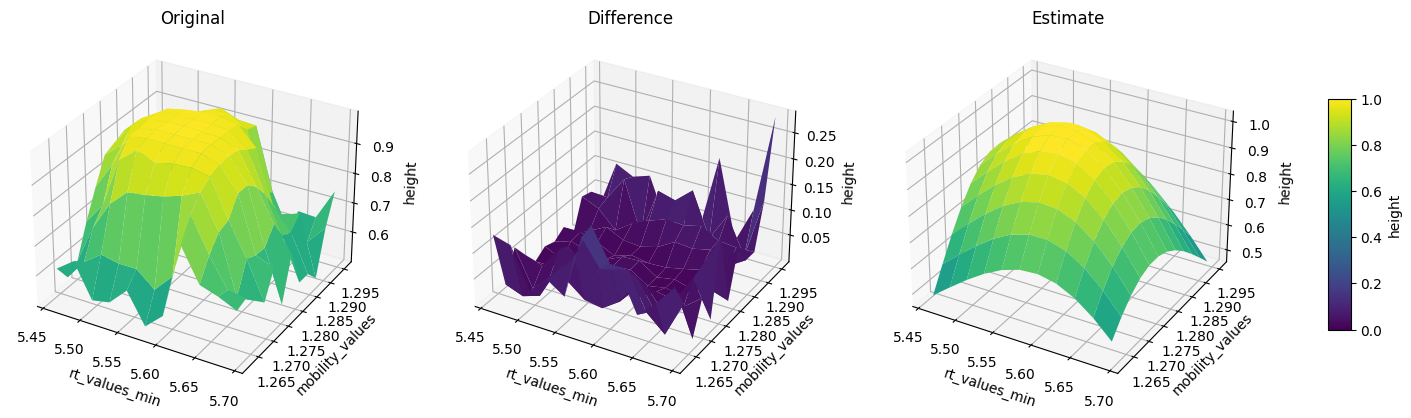

In [76]:
plot(params_emg, emg_mvd)

#### Symmetrische α-stable

Our $\beta$ is $\alpha$

\begin{equation}
p(x)=\alpha \prod_{i=1}^n \exp \left(-\left|y_i\right|^{\beta_i}\right), \quad y=A(x-\zeta) .
\end{equation}

In [ ]:
# --- Parameterzahl und Variables ---
# alpha, zeta (n), beta (n), A (n×n)
num_params = 1 + n + n + n*n
params = tf.Variable(tf.random.normal([num_params], stddev=0.1), name="ged_params")

def ged_mvd(params, X):
    # n aus Länge params errechnen oder explizit setzen
    alpha = params[0]
    zeta   = params[1:1+n]                   # Lage
    beta   = tf.abs(params[1+n:1+2*n])      # Form > 0
    A_flat = params[1+2*n:]
    A      = tf.reshape(A_flat, (n,n))      # Precision-Faktor

    # transformieren
    centered   = X - zeta                    # [N,n]
    Y          = tf.matmul(centered, A, transpose_b=True)  # [N,n]

    # component-wise GED-Dichte (bis auf Konstanten)
    # ρ_i ∝ exp(-|y|^β)
    exponent        = - tf.abs(Y)**beta      # [N,n]
    rho_components  = tf.exp(exponent)       # [N,n]

    rho = alpha * tf.reduce_prod(rho_components, axis=1)  # [N]
    return rho


In [78]:
params_ged = train(params, ged_mvd)

Epoch    0, Loss = 1.034397e+00, Best Loss = 1.034397e+00
Epoch  200, Loss = 3.347003e-02, Best Loss = 3.347003e-02
Epoch  400, Loss = 3.344303e-02, Best Loss = 3.344303e-02
Epoch  600, Loss = 3.340720e-02, Best Loss = 3.340720e-02
Epoch  800, Loss = 3.336307e-02, Best Loss = 3.336307e-02
Epoch 1000, Loss = 3.330996e-02, Best Loss = 3.330996e-02
Epoch 1200, Loss = 3.324495e-02, Best Loss = 3.324495e-02
Epoch 1400, Loss = 3.315802e-02, Best Loss = 3.315802e-02
Epoch 1600, Loss = 3.297432e-02, Best Loss = 3.297432e-02
Epoch 1800, Loss = 3.287261e-02, Best Loss = 3.207098e-02
Epoch 2000, Loss = 3.419000e-02, Best Loss = 3.199195e-02
Epoch 2200, Loss = 3.377650e-02, Best Loss = 3.199195e-02
Epoch 2400, Loss = 3.364524e-02, Best Loss = 3.199195e-02
Epoch 2600, Loss = 3.423199e-02, Best Loss = 3.199195e-02
Epoch 2800, Loss = 3.399002e-02, Best Loss = 3.199195e-02
Epoch 3000, Loss = 3.378984e-02, Best Loss = 3.199195e-02
Epoch 3200, Loss = 3.360631e-02, Best Loss = 3.199195e-02
Epoch 3400, Lo

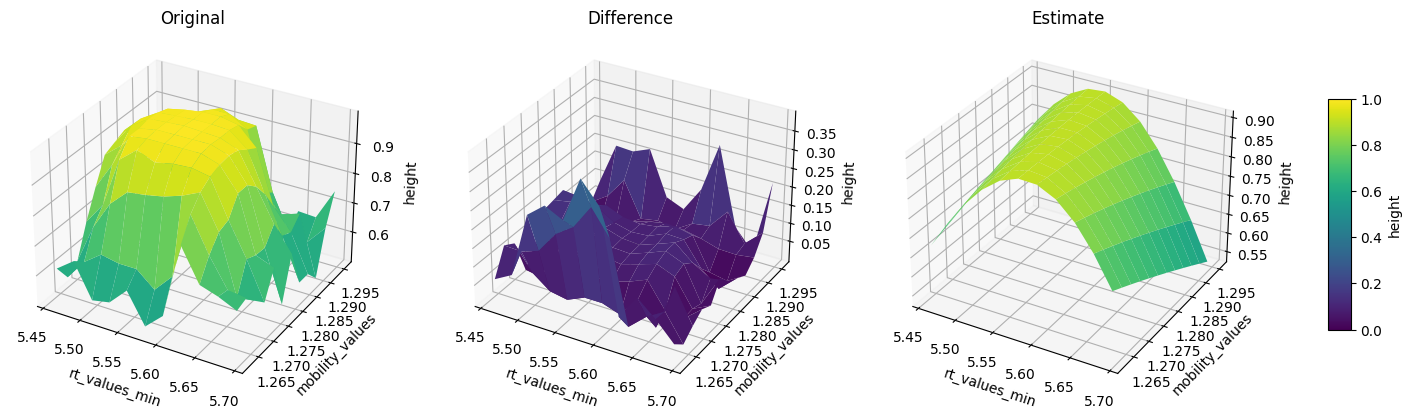

In [79]:
plot(params_ged, ged_mvd)

#### Student-t

\begin{equation}
p(x)=\alpha \prod_{i=1}^n\left(1+\frac{y_i^2}{\nu}\right)^{-\frac{\nu+1}{2}}, \quad y=A(x-\zeta) .
\end{equation}

In [88]:
# alpha, zeta(n), ν (Skalar), A(n×n)
num_params = 1 + n + 1 + n*n
params = tf.Variable(tf.random.normal([num_params], stddev=0.1), name="t_params")

def student_t_mvd(params, X):
    alpha = params[0]
    zeta  = params[1:1+n]
    nu    = tf.nn.softplus(params[1+n]) + 1e-3   # ν>0
    A_flat = params[2+n:]
    A     = tf.reshape(A_flat, (n,n))

    centered = X - zeta
    Y        = tf.matmul(centered, A, transpose_b=True)

    # univariate t-Dichte (bis auf Konstanten):
    # ρ_i ∝ (1 + y_i^2/nu)^(-(nu+1)/2)
    rho_comp = (1 + Y**2/nu)**(-0.5*(nu+1))
    rho = alpha * tf.reduce_prod(rho_comp, axis=1)
    return rho

In [ ]:
params_student = train(params, student_t_mvd)

Epoch    0, Loss = 1.061284e+00, Best Loss = 1.061284e+00
Epoch  200, Loss = 3.384343e-02, Best Loss = 3.384343e-02
Epoch  400, Loss = 3.374381e-02, Best Loss = 3.374381e-02
Epoch  600, Loss = 3.362466e-02, Best Loss = 3.362466e-02
Epoch  800, Loss = 3.347513e-02, Best Loss = 3.347513e-02
Epoch 1000, Loss = 3.328479e-02, Best Loss = 3.328479e-02
Epoch 1200, Loss = 3.304223e-02, Best Loss = 3.304223e-02
Epoch 1400, Loss = 3.273732e-02, Best Loss = 3.273732e-02
Epoch 1600, Loss = 3.237124e-02, Best Loss = 3.237124e-02
Epoch 1800, Loss = 3.197214e-02, Best Loss = 3.197214e-02
Epoch 2000, Loss = 3.160305e-02, Best Loss = 3.160305e-02
Epoch 2200, Loss = 3.134542e-02, Best Loss = 3.134542e-02
Epoch 2400, Loss = 3.120326e-02, Best Loss = 3.120326e-02
Epoch 2600, Loss = 3.099673e-02, Best Loss = 3.099673e-02
Epoch 2800, Loss = 3.040510e-02, Best Loss = 3.034980e-02
Epoch 3000, Loss = 2.914526e-02, Best Loss = 2.914526e-02
Epoch 3200, Loss = 2.852766e-02, Best Loss = 2.690217e-02
Epoch 3400, Lo

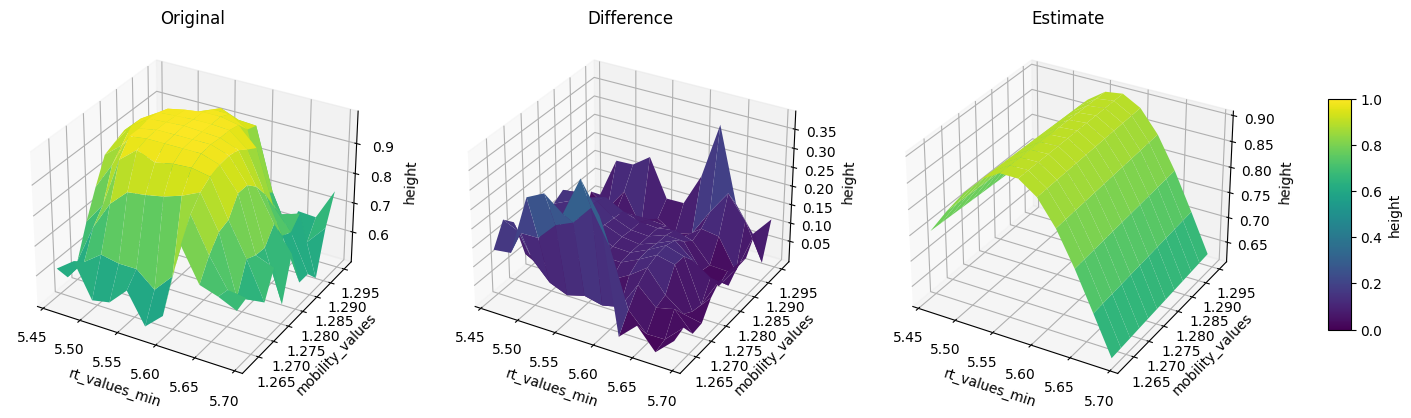

In [89]:
plot(params_student, student_t_mvd)

#### Multivariate Skew-Normal (Azzalini)

\begin{equation}
p(x)=\alpha \prod_{i=1}^n 2 \varphi\left(y_i\right) \Phi\left(\lambda_i y_i\right), \quad y=A(x-\zeta) .
\end{equation}

$\phi$ is die Dichte, $\Phi$ die Verteilungsfunktion der Normalverteilung



In [82]:
# alpha, zeta(n), shape λ(n), A(n×n)
num_params = 1 + n + n + n*n
params = tf.Variable(tf.random.normal([num_params], stddev=0.1), name="sn_params")

def skew_normal_mvd(params, X):
    alpha = params[0]
    zeta   = params[1:1+n]
    lam    = params[1+n:1+2*n]          # Schiefewinkel
    A_flat = params[1+2*n:]
    A      = tf.reshape(A_flat, (n,n))

    centered = X - zeta
    Y        = tf.matmul(centered, A, transpose_b=True)

    # Standard-Normal-Dichte und -Verteilungsfunktion
    phi = tf.exp(-0.5*Y**2)/tf.sqrt(2*tf.constant(np.pi))
    Phi = 0.5*(1 + tf.math.erf(lam*Y/tf.sqrt(2.0)))

    rho_comp = 2*phi*Phi
    rho = alpha * tf.reduce_prod(rho_comp, axis=1)
    return rho


In [83]:
params_skew_normal = train(params, skew_normal_mvd)

Epoch    0, Loss = 1.024094e+00, Best Loss = 1.024094e+00
Epoch  200, Loss = 9.999975e-01, Best Loss = 9.999975e-01
Epoch  400, Loss = 6.967791e-01, Best Loss = 6.967791e-01
Epoch  600, Loss = 3.309044e-02, Best Loss = 3.309044e-02
Epoch  800, Loss = 3.258095e-02, Best Loss = 3.258095e-02
Epoch 1000, Loss = 3.188634e-02, Best Loss = 3.188634e-02
Epoch 1200, Loss = 3.129939e-02, Best Loss = 3.129939e-02
Epoch 1400, Loss = 3.109502e-02, Best Loss = 3.109502e-02
Epoch 1600, Loss = 3.101099e-02, Best Loss = 3.101099e-02
Epoch 1800, Loss = 3.088708e-02, Best Loss = 3.088708e-02
Epoch 2000, Loss = 3.065345e-02, Best Loss = 3.065345e-02
Epoch 2200, Loss = 3.016444e-02, Best Loss = 3.016444e-02
Epoch 2400, Loss = 2.907516e-02, Best Loss = 2.907516e-02
Epoch 2600, Loss = 2.729246e-02, Best Loss = 2.727046e-02
Epoch 2800, Loss = 2.583828e-02, Best Loss = 2.583828e-02
Epoch 3000, Loss = 2.523298e-02, Best Loss = 2.523298e-02
Epoch 3200, Loss = 2.500912e-02, Best Loss = 2.500912e-02
Epoch 3400, Lo

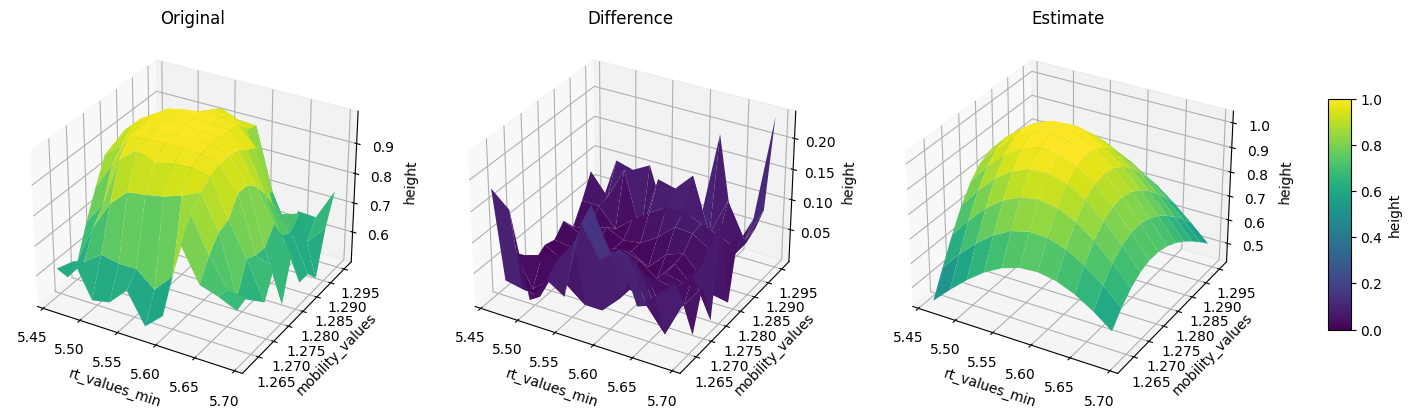

In [84]:
plot(params_skew_normal, skew_normal_mvd)

#### Pearson type IV as general distributions

The normal distribution is the limit

##### IV

\begin{equation}
\rho_i(y) \propto\left(1+y_i^2 / \nu_i\right)^{-m_i} \exp \left(n_i \arctan \left(y_i / \sqrt{\nu_i}\right)\right)
\end{equation}

In [90]:
# params = [alpha, zeta(n), m(n)>0, n(n), nu(n)>0, A(n×n)]
num_params = 1 + n + n + n + n + n*n
params = tf.Variable(tf.random.normal([num_params], stddev=0.1), name="pearsonIV")

def pearsonIV_mvd(params, X):
    alpha = params[0]
    zeta   = params[1:1+n]
    m      = tf.nn.softplus(params[1+n:1+2*n])         # m>0
    npar   = params[1+2*n:1+3*n]                       # n real
    nu     = tf.nn.softplus(params[1+3*n:1+4*n])       # ν>0
    A_flat = params[1+4*n:]
    A      = tf.reshape(A_flat,(n,n))

    Y = tf.matmul(X - zeta, A, transpose_b=True)

    # pearson IV
    term1 = (1 + (Y**2)/nu)**(-m)
    term2 = tf.exp(npar * tf.atan(Y/tf.sqrt(nu)))
    rho_i = term1 * term2
    rho = alpha * tf.reduce_prod(rho_i, axis=1)
    return rho


In [91]:
params_pearson_IV = train(params, pearsonIV_mvd)

Epoch    0, Loss = 1.011825e+00, Best Loss = 1.011825e+00
Epoch  200, Loss = 3.356126e-02, Best Loss = 3.356126e-02
Epoch  400, Loss = 3.338487e-02, Best Loss = 3.338487e-02
Epoch  600, Loss = 3.319265e-02, Best Loss = 3.319265e-02
Epoch  800, Loss = 3.294930e-02, Best Loss = 3.294930e-02
Epoch 1000, Loss = 3.248462e-02, Best Loss = 3.248462e-02
Epoch 1200, Loss = 3.158902e-02, Best Loss = 3.158902e-02
Epoch 1400, Loss = 3.040450e-02, Best Loss = 3.040450e-02
Epoch 1600, Loss = 2.718244e-02, Best Loss = 2.718244e-02
Epoch 1800, Loss = 2.670898e-02, Best Loss = 2.670898e-02
Epoch 2000, Loss = 2.664254e-02, Best Loss = 2.664254e-02
Epoch 2200, Loss = 2.657650e-02, Best Loss = 2.657650e-02
Epoch 2400, Loss = 2.651377e-02, Best Loss = 2.650862e-02
Epoch 2600, Loss = 2.643575e-02, Best Loss = 2.643467e-02
Epoch 2800, Loss = 2.636196e-02, Best Loss = 2.636196e-02
Epoch 3000, Loss = 2.628888e-02, Best Loss = 2.628888e-02
Epoch 3200, Loss = 2.622239e-02, Best Loss = 2.621843e-02
Epoch 3400, Lo

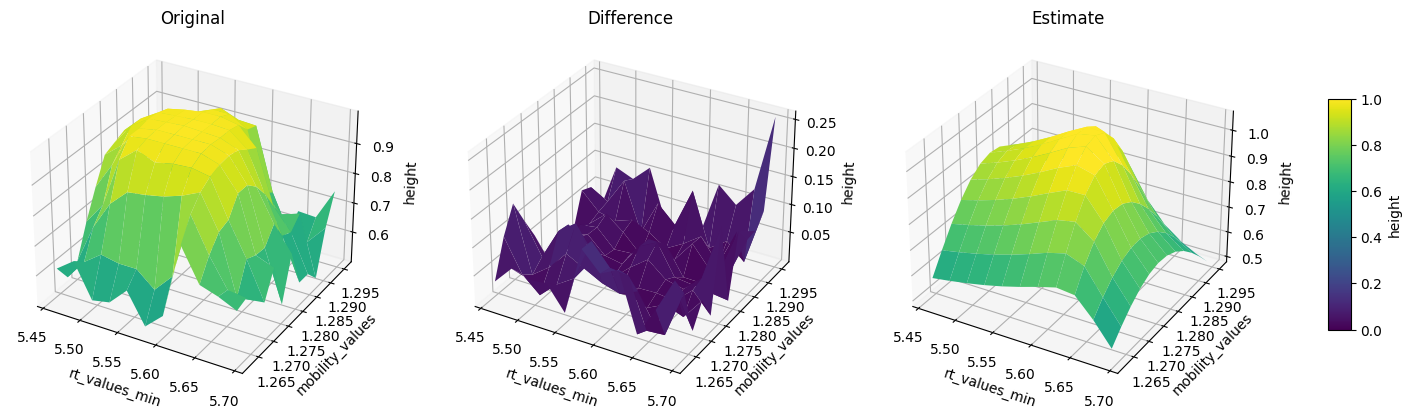

In [92]:
plot(params_pearson_IV, pearsonIV_mvd)

#### Johnson $S_U$ with matrix valued $\delta$

In [ ]:
# --- 2. Parameter als trainierbare Variablen ---
number_parameters = 2 * dimensions ** 2 + 2*dimensions + 1
params = tf.Variable(tf.random.normal([number_parameters], stddev=0.1), name="params")

# --- 3. Modell- und Fehlerfunktion definieren ---
def jsu_likelihood2(params, X):
    
    # parameter length
    n = int(-3/2+ np.sqrt(5/4 + len(params.numpy())))
    # 0: alpha
    alpha = params[0]
    # gamma
    gamma = params[1:1+n]
    # zeta
    zeta = params[1+n:1+2*n]
    # delta (absolut)
    delta_sqrt = tf.reshape(params[1+2*n:1+2*n+n*n], (n,n))
    delta = tf.matmul(delta_sqrt, delta_sqrt, transpose_b = True)

    # A-Matrix (3×3), Q = A·Aᵀ
    A = tf.reshape(params[1+2*n+n*n:], (n, n))
    #Q = tf.matmul(A, A, transpose_b=True)  # Q = A @ A.T

    # Achsentransformation: für jeden Sample-Vektor x: Q @ (x - zeta)
    centered = X - zeta                   # broadcast [N,2] - [2] → [N,2]
    transformed = tf.matmul(centered, A, transpose_b=True)  # [N,2]

    # Komponentendichten
    # rho_i = exp(-0.5*(γ_i + δ_i*asinh(t_i))²) / sqrt(1 + t_i²)
    asinh_t = tf.asinh(transformed)      # [N,2]
    exponent = -0.5 * (gamma + tf.matmul(asinh_t, delta, transpose_b=True))**2  # broadcast [2]→[N,2]
    rho_components = tf.exp(exponent) / tf.sqrt(1 + transformed**2)  # [N,2]

    # Gesamt-Wahrscheinlichkeit: α * ∏ₖ ρₖ
    rho = alpha * tf.reduce_prod(rho_components, axis=1)  # [N]
    return rho

In [56]:
params_jsu2 = train(params, jsu_likelihood2, epochs=50000)

Epoch    0, Loss = 2.369575e-02, Best Loss = 2.369575e-02
Epoch  200, Loss = 2.369529e-02, Best Loss = 2.369529e-02
Epoch  400, Loss = 2.368129e-02, Best Loss = 2.368129e-02
Epoch  600, Loss = 2.367472e-02, Best Loss = 2.367472e-02
Epoch  800, Loss = 2.366719e-02, Best Loss = 2.366719e-02
Epoch 1000, Loss = 2.365836e-02, Best Loss = 2.365836e-02
Epoch 1200, Loss = 2.364816e-02, Best Loss = 2.364816e-02
Epoch 1400, Loss = 2.363657e-02, Best Loss = 2.363657e-02
Epoch 1600, Loss = 2.362354e-02, Best Loss = 2.362354e-02
Epoch 1800, Loss = 2.360905e-02, Best Loss = 2.360905e-02
Epoch 2000, Loss = 2.359303e-02, Best Loss = 2.359303e-02
Epoch 2200, Loss = 2.357618e-02, Best Loss = 2.357618e-02
Epoch 2400, Loss = 2.355927e-02, Best Loss = 2.355927e-02
Epoch 2600, Loss = 2.354338e-02, Best Loss = 2.354305e-02
Epoch 2800, Loss = 2.352908e-02, Best Loss = 2.352703e-02
Epoch 3000, Loss = 2.351257e-02, Best Loss = 2.351109e-02
Epoch 3200, Loss = 2.349859e-02, Best Loss = 2.349604e-02
Epoch 3400, Lo

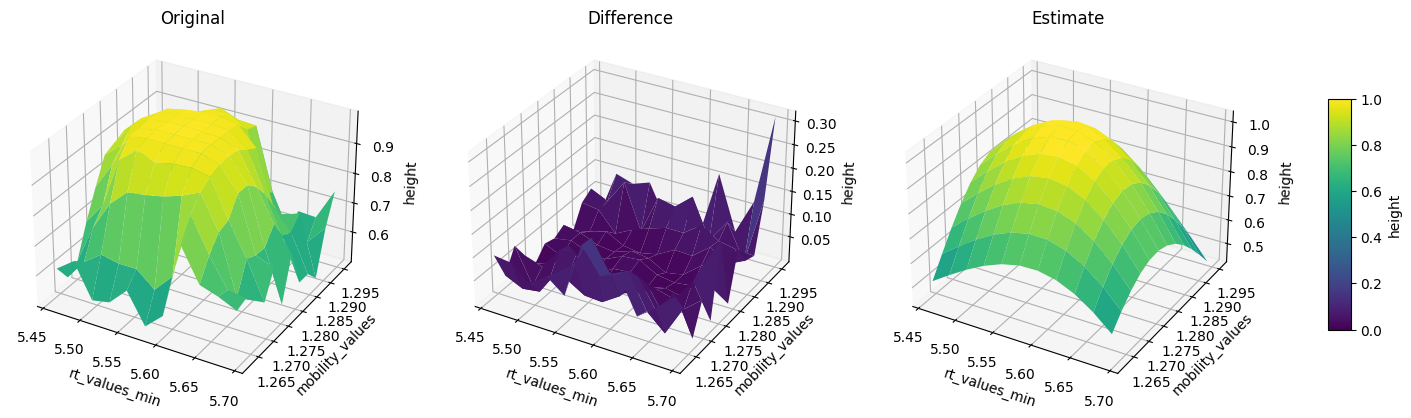

In [57]:
plot(params_jsu2, jsu_likelihood2)